### imports 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
!git clone https://github.com/oguiza/fastai_extensions.git 
!pip install pytorchcv -q

In [ ]:
from fastai_extensions.fastai_extensions import *
from fastprogress import progress_bar
from fastai.vision import *
from fastai.vision.models import **
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch 
import os 
import sys

MODELS_FOLDER = '/content/gdrive/My Drive/Colab Notebooks/shopee/models/fastai/'

torch.cuda.get_device_name()

### Copy preprocessed images from gdrive to Colab Virtual Machine (See Resizing.ipynb)
- 128 x 128 images were prepared from the original dataset provided by Shopee
- This significantly speeds up I/O & training, as compared to resizing to 128x128 on the fly 
- Clean 128 x 128 images were used to first train the fully-connected layers w/ pretrained EffNet B4

In [ ]:
!cp "/content/gdrive/My Drive/clean_128 (1).zip" "/content/"
import zipfile
import time
start = time.time()
local_zip = '/content/clean_128 (1).zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/clean_128') # goes to google colab virtual storage 
zip_ref.close()
end = time.time()
print(end-start)

12.833554983139038


In [ ]:
# !cp "/content/gdrive/My Drive/Null Sine Labore/product_detection/cleaned_data/dirty_448.zip" "/content/"
import zipfile
import time
start = time.time()
local_zip = '/content/dirty_448.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/dirty_448') # goes to google colab virtual storage 
zip_ref.close()
end = time.time()
print(end-start)

58.67742967605591


In [ ]:
path = Path('/dirty_448/data/')  
path.ls()

[PosixPath('/dirty_448/data/dirty_448'), PosixPath('/dirty_448/data/models')]

### OverSamplingCallBack to sample from imbalanced dataset
- Assigns class weights based on # images in that class 
- Classes w/ fewer images get proportionally higher weight
- Randomly samples from training dataset using this class-weighted distribution instd of a uniform probability distribution

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner, weights:torch.Tensor=None):
        super().__init__(learn)
        labels = self.learn.data.train_dl.dataset.y.items.astype(int)
        _,counts = np.unique(labels, return_counts=True)
        counts = 1. / counts
        self.weights = (weights if weights is not None else torch.DoubleTensor(counts[labels]))

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(
            WeightedRandomSampler(self.weights, len(self.learn.data.train_dl.dataset)),
            self.learn.data.train_dl.batch_size, False)

### Prepare on-the-fly image augmentations 
- I experimented w/ a whole bunch of augmentations, but ultimately these listed in the code cell below tended to train more robust models
- Your choice of augmentations is based on your dataset. 


- Perspective warp is especially useful, bcos I saw that a lot of the product images had different perspective angles 
- Zoom crop makes sense too, as merchants upload both zoomed-in photos & photos of the product/model (for clothes) against a wide background
- At the same time, more augmentations = longer training, so I had to be a bit selective
- While unfreezing, I also applied the concept of <b>'curriculum learning'</b> where the augmentations were gradually made harder as training progresses (e.g. larger cut-out sizes, higher probabilities of being applied to an image) https://mila.quebec/wp-content/uploads/2019/08/2009_curriculum_icml.pdf


- At this point, let me also emphasise the type of cut-out I used. It was not the 'classic' cut-out of 1 big black square on the image, like shown in the illustration below.
- Instead, I specified a large number of small holes (up to 30), sprinkling the entire image randomly. This has proven more effective in the CV community. It makes more sense, bcos by blocking out an entire chunk ('classic' cut-out), you really can lose a lot of semantic info from that image. e.g. imagine the cutout was on the lower half of the image of the St. Bernard doggo, only leaving the top half, which is just the ground (and no more doggo), it is difficult to say what the model can learn from such an image.
- In contrast, with 'sprinkles' cut-out, the model still sees enough pixels, and is forced to 'interpolate' info about the missing pixels. It forces the model to avoid relying too much on a single clear feature of an image (a form of regularisation).

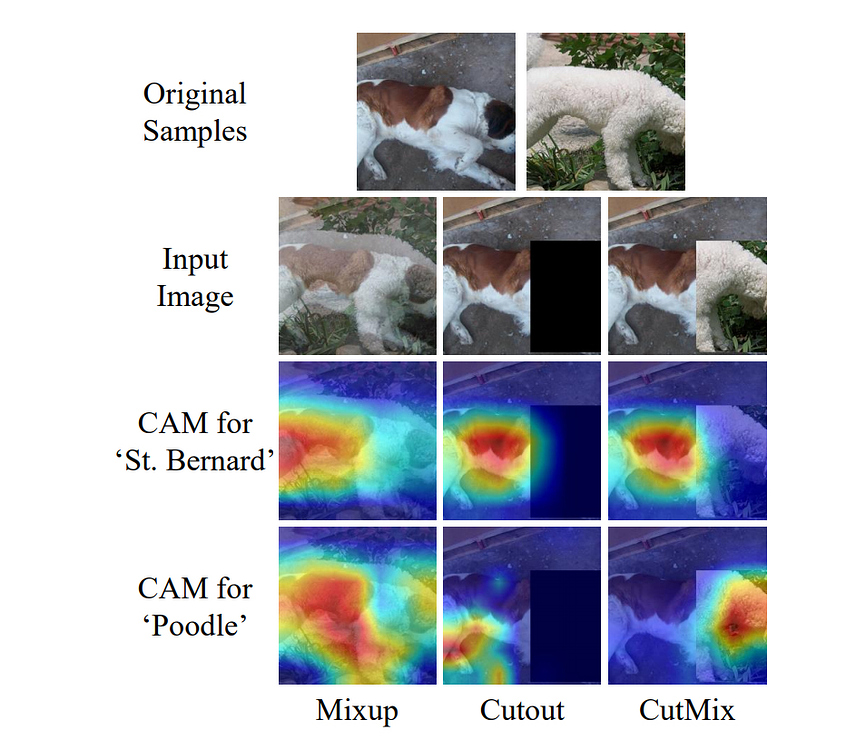

 - Also note that I used a small val set of only 7.5%, bcos the entire dataset was 100k+ images, and from training on it, this split was needed to give more training examples, and the val set was still large enough for reliable evaluation (I initially used 20/15%)
 - since the cleaned images are only 128 x 128, a large batch size of 128 could be used for faster training

In [ ]:
from fastai.vision.learner import *

src = (ImageList.from_folder(path)
      .split_by_rand_pct(0.075)
      .label_from_folder())
xtra_tfms = [pad(padding=30, mode='reflection'),
            perspective_warp(magnitude=0.15), 
             *zoom_crop(0.75, 1.25, p=0.6), 
              cutout(n_holes=(1,30), length=(25,25))]        

tfms = get_transforms(xtra_tfms=xtra_tfms) 
data = (src.transform(tfms=tfms, size=128)
          .databunch(bs=128)
          .normalize(imagenet_stats))

### LabelSmoothingCrossEntropy loss
- Label Smoothing loss forces the model to be less confident about its predictions by smoothing the ground-truth label. Normally in CrossEntropy loss, the label is a one-hot encoded (OHE) vector, which is a 'hard' label (only 1 correct answer).
- In contrast, Label Smoothing assigns some probability mass to the other classes, converting the hard OHE to a smooth distribution.
- The eqn used is $y_{\text{smooth}}$ = $(1 - \alpha) * y_{\text{ohe}} + \alpha / K $
- $K$ is the number of classes (in our case, $42$). $\alpha$ is a hyperparameter to be tuned. if $\alpha$ = 0, we recover the original $y_{\text{ohe}}$. if $\alpha = 1 $, we just get a uniform distribution where each value of the $y_{\text{smooth}}$ vector is $\alpha/K$. In my case, I just used the fast.ai default value of $0.1$, which was the value used by the original paper  https://arxiv.org/abs/1906.02629


- The gradient of the CrossEntropyLoss wrt logits from the model is: $\nabla CrossEntropyLoss$ = $p - y$ = $softmax(logits) - y$. Through gradient descent, the minima reached (aka $\nabla CrossEntropyLoss = 0$) corresponds to making $p$ match $y$ as closely as possible. This encourages the model to output as large of logits as possible for the correct class, and as low logits as possible for all wrong classes. i.e. maximise the difference 
- At the same time, the gradient is bounded between $-1$ and $1$, since each value of $p$ is between $0$ and $1$, and $y$ is either $0$ or $1$. 
- With large logit gap, but relatively small gradient values, the model becomes less adaptive once a large logit gap is reached. This 'locks in' the model's predictions about a certain image, and often results in over-confidence. 


- To give a numerical example, if $K = 4$, suppose a $y_{\text{ohe}}$ = $[0, 1, 0, 0]$ (2nd class is correct). To match this vector, the model's output logits would be $[0, 9, 0, 0]$ which after softmax is $[0, 0.999, 0, 0]$ (3 d.p.) 
- In contrast, with $\alpha$ = 0.1, $y_{\text{smoothed}}$ = $[0.025, 0.925, 0.025, 0.025]$. The logit vector needed to match this is only $[0, 3.611, 0, 0]$, where the maximum logit value for class $2$ is about $3$ times smaller than the original logit of $9$. 

In [ ]:
loss_func = LabelSmoothingCrossEntropy()

### Fetch pretrained EfficientNet
- B4 was chosen as compromise btwn accuracy & model complexity
- Time wasn't exactly abundant

In [ ]:
!pip install efficientnet_pytorch -q

In [ ]:
from efficientnet_pytorch import EfficientNet
effnet = EfficientNet.from_pretrained('efficientnet-b4', num_classes=42)
learn = Learner(data, effnet, metrics=accuracy, loss_func=loss_func).to_fp16().mixup().batch_loss_filter()
del effnet

# set layer_groups to gradually unfreeze during training
learn.layer_groups = learn.layer_groups[0][:284], learn.layer_groups[0][284:509], learn.layer_groups[0][509:]

Loaded pretrained weights for efficientnet-b4


use Kaiming He's method to init FC layer https://arxiv.org/abs/1502.01852
- for a nice article on why proper weight initialisation is important: https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79 

In [ ]:
# only run this ONCE at the very start after loading freshly pretrained weights

# apply_init(learn.layer_groups[2], nn.init.kaiming_normal_)

### Start training
- freeze all convolutional layers of pretrained EffNet (i.e. use it as feature extractor, even though it may not excel at recognising e-commerce products)
- 'warm up' the fully-connected layer(s) first
- this is crucial, as the fully-connected layer(s) have just been initialised, with 'nonsense' gradients. if we just train the whole model together, the FC layer will 'mess up' the gradients that are backpropagated from the loss through the FC layer and then to the conv layers. This has been found to be adverse to learning

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


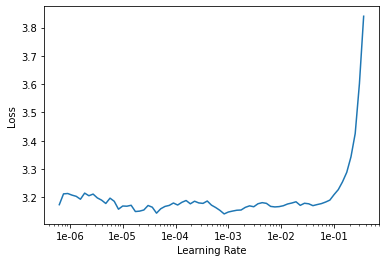

In [ ]:
learn.lr_find(wd=0)
learn.recorder.plot()

### the initial accuracy starts off small, but quickly increases as the FC-layer gets warmed up
- I use ReduceLROnPlateau, which lowers the learning rate when the validation loss increases (hint of overfitting). This often combats the overfitting for a few more epochs and allows the model to get an extra push in accuracy before it overfits again. 
- MixedPrecision training speeds up computations on GPU by using fp16 instead of fp32. float16 takes up less memory (16 bits vs 32 bits), and is also faster to compute if the hardware is specialised to run 16-bit computations.
- However, this also means the GPU has to support fp16 to enjoy the speed benefit, and it comes with some extra work, like knowing exactly whether you are in fp16 or fp32 mode, not being compatible w/ some user-made/dev features like BatchLossFilter (and therefore needing me to go into the abstractions and code a few extra lines to enable fp16 support), needing to convert your model & weights back to fp32 before exporting etc. but it's worth it if your training takes a long time.

In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_0'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-7), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.fit_one_cycle(2, slice(1e-2), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.297792,2.596222,0.390012,07:56
1,2.971686,2.223638,0.503325,07:48


Better model found at epoch 0 with accuracy value: 0.3900122046470642.
Better model found at epoch 1 with accuracy value: 0.5033247470855713.


In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_1'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-7), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.fit_one_cycle(2, slice(5e-3), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.052344,2.205709,0.502510,07:50
1,2.939795,2.081414,0.556249,07:53


Better model found at epoch 0 with accuracy value: 0.5025104880332947.
Better model found at epoch 1 with accuracy value: 0.5562491416931152.


### After training for 4 epochs above, I added BatchLossFilter and also rotated augmentations 
- The changing augmentations is why the train loss suddenly seems a lot lower (some augmentations are particularly difficult, and result in higher train loss)
- BatchLossFilter is just an additional trick to speed up training. In short, it is a form of selective backpropagation, where we only select training examples with the biggest loss to backprop the gradients. <b>This speed up comes with no noticeable drop in accuracy</b>, which is really nice. https://arxiv.org/pdf/1910.00762

- In my case, I didn't observe this for 128 x 128, most likely bcos I was training 2 epochs at a time, but I think you need to train for say 10+ epochs at a time to extract the speed up. Also, the augmentations were a significant bottleneck and the epoch is relatively fast to begin with. But it's a nice tool you can consider.
- <u> However, when I trained on 448 x 448, there was a clear speed-up (from 1 hr 10 mins to maybe 1 hr)</u>

In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_2'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-7), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.freeze()
learn.fit_one_cycle(2, slice(5e-3), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,loss_perc,samp_perc,time
0,0.788586,2.120394,0.549871,1.000000,1.000000,07:58
1,0.817064,2.024728,0.588004,0.902087,0.779978,08:07


Better model found at epoch 0 with accuracy value: 0.5498710870742798.
Better model found at epoch 1 with accuracy value: 0.5880038142204285.


In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_3'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-7), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.freeze()
learn.fit_one_cycle(2, slice(5e-3), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,loss_perc,samp_perc,time
0,2.741173,1.945221,0.585968,1.000000,1.000000,07:56
1,3.038830,1.884961,0.619351,0.902060,0.771496,08:02


Better model found at epoch 0 with accuracy value: 0.5859682559967041.
Better model found at epoch 1 with accuracy value: 0.619351327419281.


### unfreeze

In [ ]:
learn.batch_loss_filter()

epoch,train_loss,valid_loss,accuracy,loss_perc,samp_perc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


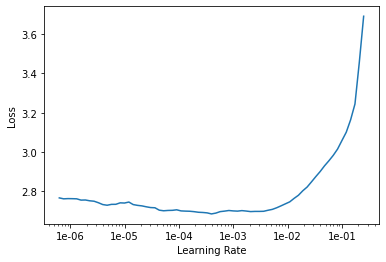

In [ ]:
learn.unfreeze()
learn.lr_find(wd=0)
learn.recorder.plot()

In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_stage20'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-7), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.unfreeze()
learn.fit_one_cycle(1, slice(4e-5, 4e-4), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,2.508326,1.708610,0.665762,09:01


Better model found at epoch 0 with accuracy value: 0.6657619476318359.


### After training on the clean dataset, I switch to the original 'dirty' Shopee dataset 
- This dataset contains a lot of mislabelled images (e.g. clock image in clothes folder), and also a bunch of nonsense images (like company logo, SMS messages) 
- This decision was made after I submitted predictions from a model trained just on the cleaned dataset, and the public leaderboard score was very bad. While I hit 92% acc on cleaned test set, the leaderboard accuracy was around 79% only.
- From this, I gathered that the leaderboard test set is equally, if not more dirty of a dataset, and a model trained just on the cleaned data is not able to handle this 'uncertainty'
- <u>My reason for training first on cleaned data is that I wanted the Conv layers to 'correctly' learn the distinguishing features of this particular Shopee dataset first, without all the nonsense from the wrongly labeled images and so on. </u> 
- I hoped that this would direct the entire model to a better local minima later when training on the dirty dataset.
<br> 


- Another thing to note is that I used 128 x 128 first, and later switch to 448 x 448. This is called <b>Progressive Resizing</b>. It works surprisingly well, allowing me to reach high accuracy in relatively few epochs. 
- Why does this work? Using lower-res images allows the model to learn 'coarse' features. i.e. features that do not require highly specific details down to the last pixel. Imagine classifying a banana vs blackberries. The color alone could be an important coarse feature, which is applicable to bigger, higher-res images too. 
- In contrast, intricate/fine features, like say 'density of spots on the skin' for a banana vs blackberry, may not be observable in most low-res images. 
- So, training on small images makes the model learn coarse, but the most important & robust features. Once these are learnt, the model will have a more productive time learning more complex features in larger images.

In [ ]:
path = Path('/dirty_448/data/')  
path.ls()

[PosixPath('/dirty_448/data/dirty_448'), PosixPath('/dirty_448/data/models')]

- Note that I first trained for a few epochs on the full dirty dataset until val accuracy was about 80+%. 
- After that, I only used 33% of the entire dirty dataset (validation was 10% of entire dataset, aka 10k+ images), simply bcos time was running out, and 448x448 images are very big and take a long time to train (over an hour for an epoch! esp w/ the augmentations)
- The lack of time was mainly bcos I had been trying out a lot of these augmentations, different model types (Inception, ResNet, ResNext), even new optimizers like the Ranger. <u>This experimentation process came with a lot of debugging, more than I would have liked.</u> Even fetching different pre-trained models wasn't straightforward, e.g. needed porting from PyTorch into fast.ai, and some of the packages weren't exactly beginner-friendly. Plus, I was a beginner in fast.ai and using some of these augmentations (which are really new, btw) required digging into their forums, and diving a bit into the abstractions (that fast.ai does really well at hiding hahaha). But it was satisfying when I managed to piece together everything! 


- <u>On hindsight, I really should have used small subsets right from the beginning, to speed up experimentation. I wasted too much time trying some methods without good results, as training was taking very long (I sadly didn't know that fast.ai has a built-in method for it already) </u>
- I also should have started with EffNet from the beginning, as it is significantly faster to train than other models like ResNext/ResNet, especially the deeper ones that I was using (101/152). I could have used maybe EffNetB3/4 for experiments and finally train a B7 to get the best accuracy. I will take note of this for future comps!
- <u>I should also have explored Kaggle TPU kernels.</u> It appears that Kaggle TPUs are very fast. HOWEVER, fast.ai at that time did not support TPUs out of the box, plus I was not as familiar with tensorflow (I knew it, but not well enough to add custom augmentations or callbacks, or to create/manipulate TFRecords), and I already spent a good amount of time learning fast.ai; there wasn't much time left for me to go deep into another deep learning framework. But I have seen Kaggle kernels showing very fast training w/ excellent results using Kaggle TPUs. So, I will try both Kaggle TPUs and Colab TPUs + tensorflow in the future.

In [ ]:
from fastai.vision.learner import *
from fastai.vision.learner import num_features_model, create_body, create_head

src = (ImageList.from_folder(path)
      .split_subsets(0.33, valid_size=0.1)
      .label_from_folder())
xtra_tfms = [pad(padding=30, mode='reflection'),
            perspective_warp(magnitude=0.15), 
             *zoom_crop(0.75, 1.25, p=0.6), 
              cutout(n_holes=(1,30), length=(25,25))
          ]            
tfms = get_transforms(do_flip=True, xtra_tfms=xtra_tfms) 
data = (src.transform(tfms=tfms, size=448)
          .databunch(bs=32)
          .normalize(imagenet_stats)
          )
loss_func = LabelSmoothingCrossEntropy()

### Not shown here, but I unfreezed the FC layer 1st to warm them up before unfreezing the Conv layers

In [ ]:
from efficientnet_pytorch import EfficientNet
effnet = EfficientNet.from_pretrained('efficientnet-b4', num_classes=42)
learn = Learner(data, effnet, metrics=accuracy, loss_func=loss_func).cutmix().batch_loss_filter().to_fp16()
learn.layer_groups = learn.layer_groups[0][:284], learn.layer_groups[0][284:509], learn.layer_groups[0][509:]

learn.unfreeze()
del effnet
learn.load(MODELS_FOLDER+'EffNet_b4_v1_stage3').to_fp16()

epoch,train_loss,valid_loss,accuracy,loss_perc,samp_perc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


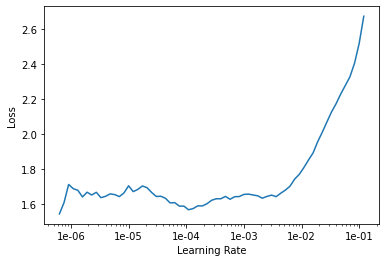

In [ ]:
learn.lr_find(wd=0)
learn.recorder.plot()

### I first trained for about 8 epochs on the full dirty dataset (~9-10 hrs) (basically overnight)
- Here, an interesting technique I used was rotational augmentation, which I read about on the fast.ai forums. Some of the deep learning experts there have used this to great success to beat fast.ai SOTA benchmarks on ImageNet. 
- They claim that changing the augmentations increases robustness to them. I mean, they have the accuracies to show for it, so why not. 
- <b> It has been reported in CV papers that turning off an augmentation half-way during training offers a significant 'jump' in model performance after that, more so than keeping it turned on throughout. I suppose a related effect is manifesting itself here. </b> https://arxiv.org/abs/2002.08973 see this paper too
- There isn't really a fixed formula for doing it, but here is how I did mine. I didn't have time to experiment with this too much, so there is probably room for improvement. These 3 'vanilla' transforms were kept for all epochs: <br> Pad, Perspective Warp, Zoom Crop <br> 
<br>
&nbsp; &nbsp; 1. MixUp(alpha=0.4) for ~2 epochs (fast.ai callback) <br>
&nbsp; &nbsp; 2. Sprinkles (aka Cut-out w/ up to 30 holes, each 25x25 pixels for 3 epochs, but each epoch I increase the fixed_prob gradually aka curriculum learning) <br>
&nbsp; &nbsp; 3. CutMix (fast.ai callback)<br> 
&nbsp; &nbsp; 4. RICAP (beta = 0.5) <br>
<br> 

Note: The code for RICAP is from https://github.com/oguiza/fastai_extensions <br> For sprinkles, he has an implementation as well, 'blend_type': 'zero' in https://github.com/oguiza/fastai_extensions/blob/master/02_data_augmentation_blend.ipynb which is essentially the same

### Below code is when I trained for ~6-7 more epochs after I woke up, on 33% of the data, to push the accuracy a bit more (cell output doesn't show everything).  As you can see, even with this subset, it takes 26 min/epoch.
- Note that the accuracy shown here is misleadingly high. I think I just luckily got an easy validation subset (probably the images were mostly correctly labeled) for this particular set of epochs. The val accuracy when I was training overnight was about 80% or so, and my val acc's have so far closely matched the leaderboard values. I have a feeling the .split_subsets() method I used to get 33% of data for training somehow wasn't shuffling the val set every epoch. 
- The public leaderboard accuracy was about 83%, a little lower than the private leaderboard score, which was ~83.3%. This outperformed my previous best model (ResNext101) by 3-4 absolute %, so I was already very happy with that boost. Furthermore, by this time, it was almost deadline, and I sadly couldn't try more things.

In [ ]:
from fastai.callbacks import *
callbacks = [SaveModelCallback(learn, every='improvement', monitor='accuracy', name=MODELS_FOLDER+'EffNet_b4_v1_stage4'), \
              EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.005, patience=2), \
             ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=0, min_lr=1e-8), \
             MixedPrecision(learn), \
             OverSamplingCallback(learn)]

learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-6,2e-5), wd=0, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,1.744208,0.932264,0.933770,26:22
1,1.649282,0.926186,0.932631,26:22
2,1.672320,0.929638,0.933106,26:23


Better model found at epoch 0 with accuracy value: 0.9337698221206665.
Epoch 1: reducing lr to 3.24636530891813e-06
Epoch 2: reducing lr to 1.1318883788975243e-06


KeyboardInterrupt: ignored

### reports
- fast.ai has nice built-in tools to visualise the performance of the trained model
- e.g. show a ConfusionMatrix
- there is a nice option to show the top K misclassified images
- there is also a tool to visualise the model's activation heatmaps superimposed on the images

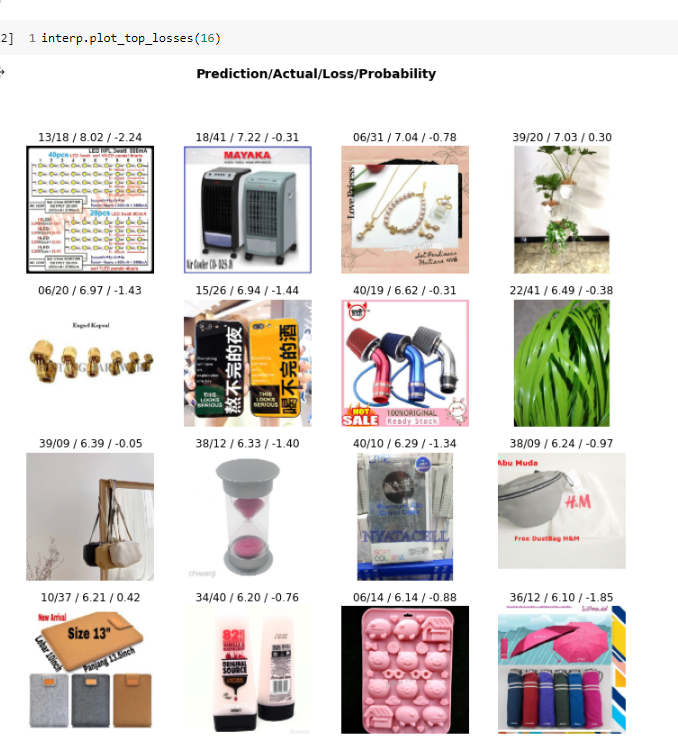

In [ ]:
from fastai.vision import *
from fastai.widgets import ClassConfusion

interp = ClassificationInterpretation.from_learner(learn)

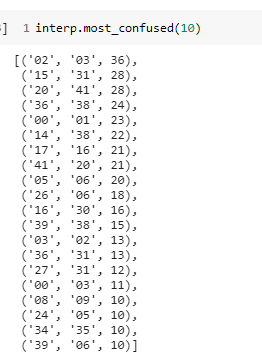

### test & generate predictions
- I tried Test Time Augmentations (fast.ai supports this), but this significantly lowered my leaderboard score (3-4 absolute %). I suppose the augmentations I am using are particularly hard (persp warp, sprinkles, zoom crop etc.), and just make it too hard for the model to reach its best classification performance

In [ ]:
!cp "/content/gdrive/My Drive/Colab Notebooks/shopee/zips/test.zip" .
import zipfile
import time
start = time.time()
local_zip = 'test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/test_new') # goes to google colab virtual storage 
zip_ref.close()
end = time.time()
print(end-start)

31.64828062057495


In [ ]:
learn.load(MODELS_FOLDER+'EffNet_b4_v1_stage3')

In [ ]:
os.makedirs('/content/gdrive/My Drive/effnet')

In [ ]:
path.ls()
learn.to_fp32() # revert to full precision
learn.export('/content/gdrive/My Drive/effnet/export_effnetv4.pkl')

In [ ]:
learn_effnet = load_learner(Path('/content/gdrive/My Drive/effnet/'), 
                            file='export_effnetv4.pkl',
                            test=ImageList.from_folder('/test_new/')) 

In [ ]:
preds_noTTA_effnet_v2, y = learn_effnet.get_preds(ds_type=DatasetType.Test)

In [ ]:
labels = np.argmax(preds_noTTA_effnet_v2, 1)
test_index = []
num = len(learn_effnet.data.test_ds)
for i in range(num):
    test_index.append(str(learn_effnet.data.test_ds.items[i]).split('/')[-1])
    
df = (pd.DataFrame(data={"filename": test_index, "category": labels})).set_index('filename')
df.category = df.category.apply(lambda c: str(c).zfill(2))
DATA_FOLDER = '/content/gdrive/My Drive/Colab Notebooks/shopee/'
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/shopee/final_submission.csv')

In [ ]:
import IPython.display as display
display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True)